## Description

This notebooks creates model from images of documents
It will choose the best model to use with them and then eliminate some features to get the better result

### Import DATA

In [5]:
import pandas as pd
import os
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_transformer
import multiprocessing
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.preprocessing import MinMaxScaler
import joblib

In [6]:
pd.set_option('display.max_columns', None)

In [7]:
screenshots = pd.read_csv("./images/screenshots/screenshots.csv")

screenshots_ph = pd.read_csv("./images/screenshots_ph/screenshots_ph.csv")

regulars = pd.read_csv("./images/regular/regular.csv")

not_good = pd.read_csv("./images/not_good/not_good.csv")

superb = pd.read_csv("./images/superb/superb.csv")

blinked = pd.read_csv("./images/blinked/blinked.csv")

docs = pd.read_csv("./images/docs/docs.csv")

test = pd.read_csv("./images/test/test.csv")


### Labeling and spliting

In [8]:
# from_labels = ["blinked", "docs", "not_good", "receipts", "regular", "screenshots", "screenshots_ph", "superb", "test"]

label = "docs"

blinked[label] = 0
regulars[label] = 0
not_good[label] = 0
superb[label] = 0
screenshots[label] = 0
docs[label] = 1
screenshots_ph[label] = 0



whole_docs = pd.concat([regulars, not_good, superb, screenshots, docs, screenshots_ph], ignore_index=True)

In [9]:
whole_docs = whole_docs.drop(columns=["filename"])

In [10]:
whole_docs = whole_docs.fillna(0)

In [11]:
y = whole_docs.pop(label)

In [12]:
X_train, X_test, y_train, y_test = train_test_split(whole_docs, y, test_size=0.15, random_state=42)

## Running on 4 Classifiers

### ExtraTree simple

In [13]:
import classifiers_3 as c3

In [14]:
search_scr = c3.extratrees_model(X_train, y_train, c3.param_et)


    Usage of 3classifiers.py:
        from 3classifiers import extratrees_model
    Usage example:
        best_model = extratrees_model(X_train, y_train, param_grid)

   Predefined examples:          
          param_extratrees = {'n_estimators': range(100, 400, 50), 'min_samples_split': range(2, 19, 2), 'min_samples_leaf': range(1, 13, 2)}
    
Fitting 10 folds for each of 324 candidates, totalling 3240 fits
Time taken to train the model: 5 minutes and 9.53 seconds
Best parameters: {'extratreesclassifier__min_samples_leaf': 1, 'extratreesclassifier__min_samples_split': 2, 'extratreesclassifier__n_estimators': 150}
Best score: 0.9754600200736032


### CatBoost

In [15]:
search_cb = c3.catboost_model(X_train, y_train, c3.param_cb)


    Usage of 3classifiers.py:
        from 3classifiers import catboost_model
    Usage example:
        best_model = catboost_model(X_train, y_train, param_grid)

   Predefined examples:          
          param_catboost = {'iterations': range(100, 400, 50), 'depth': range(4, 10, 2), 'l2_leaf_reg': array([1.00000000e-20, 3.16227766e-20, 1.00000000e-19])}
    
Fitting 10 folds for each of 54 candidates, totalling 540 fits
Time taken to train the model: 20 minutes and 48.67 seconds
Best parameters: {'catboostclassifier__depth': 6, 'catboostclassifier__iterations': 300, 'catboostclassifier__l2_leaf_reg': 1e-20}
Best score: 0.977096018735363


### LGBMClassifier

In [16]:
param_lgbm = {
        'n_estimators': range(100, 400, 50), 
        'num_leaves': range(20, 40, 5), 
        'min_child_samples': range(1, 20, 2)
}

search_lgbm = c3.lgbm_model(X_train, y_train, c3.param_lgbm)


    Usage of 3classifiers.py:
        from 3classifiers import lgbm_model
    Usage example:
        best_model = lgbm_model(X_train, y_train, param_grid)

   Predefined examples:          
          param_lgbm = {'n_estimators': range(100, 400, 50), 'num_leaves': range(20, 40, 5), 'min_child_samples': range(1, 20, 2)}
    
Fitting 10 folds for each of 240 candidates, totalling 2400 fits
[LightGBM] [Info] Number of positive: 681, number of negative: 1764
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005021 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 21712
[LightGBM] [Info] Number of data points in the train set: 2445, number of used features: 94
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.278528 -> initscore=-0.951777
[LightGBM] [Info] Start training from score -0.951777
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits wit

### AdaBoost

In [17]:
param_adaboost = {
        'n_estimators': range(50, 400, 50), 
        'learning_rate': [0.01, 0.1, 1.0],
        'estimator__max_depth': [1, 2, 3]
}

search_ab = c3.adaboost_model(X_train, y_train, c3.param_adaboost)


    Usage of 3classifiers.py:
        from 3classifiers import adaboost_model
    Usage example:
        best_model = adaboost_model(X_train, y_train, param_grid)

   Predefined examples:          
          param_adaboost = {'n_estimators': range(50, 400, 50), 'learning_rate': [0.01, 0.1, 1.0], 'estimator__max_depth': [1, 2, 3]}
    
Fitting 10 folds for each of 63 candidates, totalling 630 fits
Time taken to train the model: 17 minutes and 39.55 seconds
Best parameters: {'adaboostclassifier__estimator__max_depth': 2, 'adaboostclassifier__learning_rate': 1.0, 'adaboostclassifier__n_estimators': 350}
Best score: 0.9811876881900302


### All 4 classifiers comparison

In [18]:
best_score_et = search_scr.best_score_
best_score_lgbm = search_lgbm.best_score_
best_score_catboost = search_cb.best_score_
best_score_adaboost = search_ab.best_score_

# Create a list to display the results
results = [
    ('Extra Trees', best_score_et),
    ('LightGBM', best_score_lgbm),
    ('CatBoost', best_score_catboost),
    ('AdaBoost', best_score_adaboost)
]

# Print the results in a tabular format
print(f"{'Classifier':<15}{f'Best Score - {label}'}")
for name, score in results:
    print(f"{name:<15}{score:.4f}")

Classifier     Best Score - docs
Extra Trees    0.9755
LightGBM       0.9808
CatBoost       0.9771
AdaBoost       0.9812


In [19]:
results = [search_scr, search_lgbm, search_cb, search_ab]

results_with_identifiers = [
    (search_scr, 'scr'),
    (search_lgbm, 'lgbm'),
    (search_cb, 'cb'),
    (search_ab, 'ab')
]

classifier_mapping = {
    'scr': 'ExtraTrees',
    'lgbm': 'LightGBM',
    'cb': 'CatBoost',
    'ab': 'AdaBoost'
}

named_steps_estimator = {
    'scr': 'extratreesclassifier',
    'lgbm': 'lgbmclassifier',
    'cb': 'catboostclassifier',
    'ab': 'adaboostclassifier'
}


best_model, best_identifier = results_with_identifiers[0]

for model, identifier in results_with_identifiers[1:]:
    if model.best_score_ > best_model.best_score_:
        best_model = model
        best_identifier = identifier

# Use best_identifier to get the classifier name from the mapping
classifier_name = classifier_mapping.get(best_identifier, 'Unknown')
nsteps = named_steps_estimator.get(best_identifier)

## Confusion matrix

In [20]:
filenames = test.pop("filename")
label

'docs'

In [21]:
prediction = best_model.predict(test)

result = pd.DataFrame()
result['filename'] = filenames
result['prediction'] = prediction

result.loc[(result.prediction == 1) & (result.filename.str.contains(label)), "metric"] = "true"
result.loc[(result.prediction == 0) & (result.filename.str.contains(label)), "metric"] = "FN"
result.loc[(result.prediction == 0) & (~result.filename.str.contains(label)), "metric"] = "not true"
result.loc[(result.prediction == 1) & (~result.filename.str.contains(label)), "metric"] = "FP"

result.groupby("metric").count()

,filename,prediction
metric,,
FN,2,2
FP,3,3
not true,80,80
true,9,9


In [22]:
result.loc[result.metric == "FP"]

,filename,prediction,metric
26,receipt777.JPG,1,FP
63,screenshots (2).JPG,1,FP
65,screenshots (3).JPG,1,FP


#### Confusion matrix representation

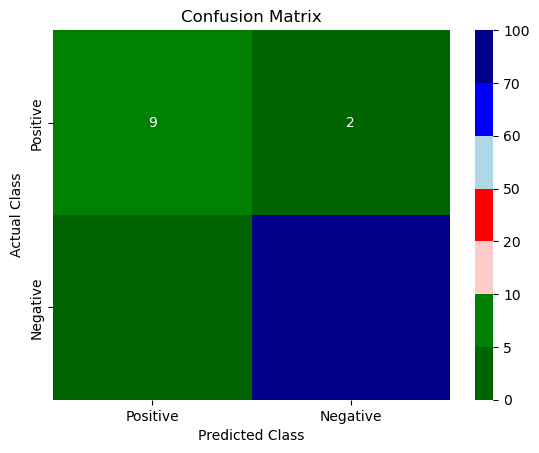

In [23]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns
from matplotlib.colors import ListedColormap, BoundaryNorm

# Define your color boundaries and corresponding colors
boundaries = [0, 5, 10, 20, 50, 60, 70, 100]  # Assuming 80 is your max value
colors = [
    'darkgreen',  # 0-5
    'green',      # 5-10
    '#ffcccc',    # 10-20 (light red)
    'red',        # 20-50
    'lightblue',  # 50-60
    'blue',       # 60-70
    'darkblue'    # above 70
]

# Create a colormap
custom_cmap = ListedColormap(colors)
norm = BoundaryNorm(boundaries, custom_cmap.N, clip=True)


tp = sum(result['metric'] == 'true')  
fn = sum(result['metric'] == 'FN')    
tn = sum(result['metric'] == 'not true')  
fp = sum(result['metric'] == 'FP') 

conf_matrix = np.array([[tp, fn],
                        [fp, tn]])

# You can then plot this using seaborn or matplotlib
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap=custom_cmap, norm=norm, 
            xticklabels=['Positive', 'Negative'], 
            yticklabels=['Positive', 'Negative'])
plt.ylabel('Actual Class')
plt.xlabel('Predicted Class')
plt.title('Confusion Matrix')
plt.show()

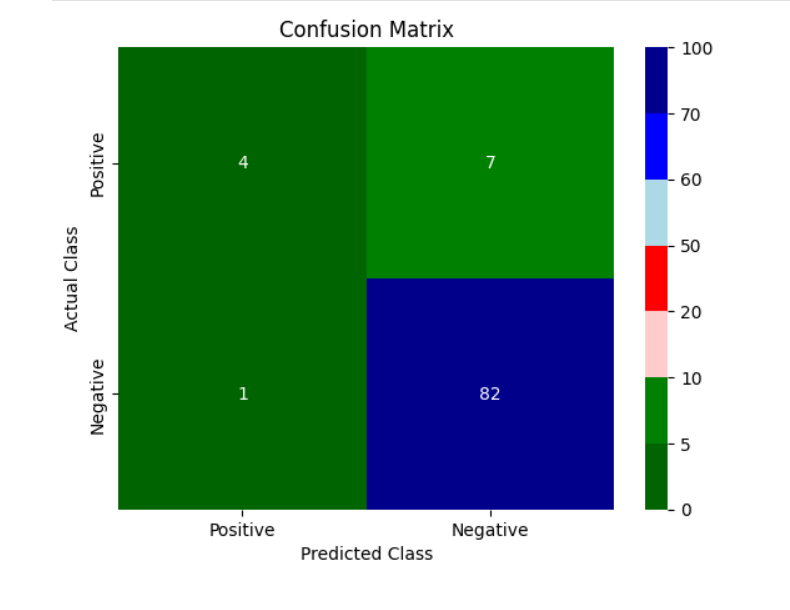

__________________

## Eliminating  features

In [24]:
from sklearn.feature_selection import RFECV

In [25]:
best_estimator = best_model.best_estimator_

In [26]:
search_RFE = RFECV(best_estimator.named_steps[nsteps], cv=10, scoring="accuracy", n_jobs = multiprocessing.cpu_count() - 1, verbose=3)

In [27]:
%%time
search_RFE.fit(X_train, y_train)

Fitting estimator with 94 features.
Fitting estimator with 93 features.
Fitting estimator with 92 features.
Fitting estimator with 91 features.
Fitting estimator with 90 features.
Fitting estimator with 89 features.
Fitting estimator with 88 features.
Fitting estimator with 87 features.
Fitting estimator with 86 features.
Fitting estimator with 85 features.
Fitting estimator with 84 features.
Fitting estimator with 83 features.
Fitting estimator with 82 features.
Fitting estimator with 81 features.
Fitting estimator with 80 features.
Fitting estimator with 79 features.
Fitting estimator with 78 features.
Fitting estimator with 77 features.
Fitting estimator with 76 features.
Fitting estimator with 75 features.
Fitting estimator with 74 features.
Fitting estimator with 73 features.
Fitting estimator with 72 features.
Fitting estimator with 71 features.
Fitting estimator with 70 features.
CPU times: total: 7min 25s
Wall time: 33min 10s


RFECV(cv=10,
      estimator=AdaBoostClassifier(estimator=DecisionTreeClassifier(max_depth=2),
                                   n_estimators=350),
      n_jobs=11, scoring='accuracy', verbose=3)

In [28]:
prediction = search_RFE.predict(test)

result = pd.DataFrame()
result['filename'] = filenames
result['prediction'] = prediction

result.loc[(result.prediction == 1) & (result.filename.str.contains(label)), "metric"] = "true"
result.loc[(result.prediction == 0) & (result.filename.str.contains(label)), "metric"] = "FN"
result.loc[(result.prediction == 0) & (~result.filename.str.contains(label)), "metric"] = "not true"
result.loc[(result.prediction == 1) & (~result.filename.str.contains(label)), "metric"] = "FP"

result.groupby("metric").count()

,filename,prediction
metric,,
FN,2,2
FP,5,5
not true,78,78
true,9,9


# Confusion Matrix after eliminating features

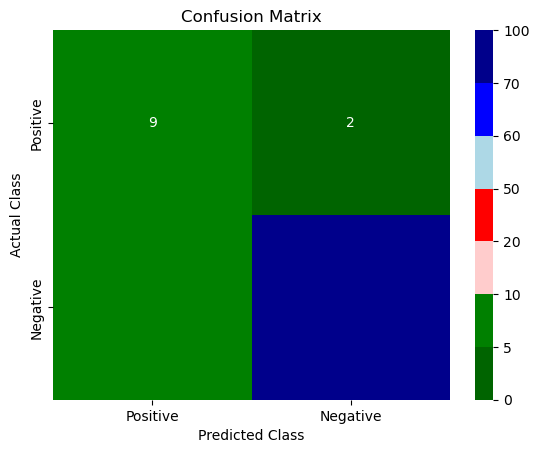

In [29]:
boundaries = [0, 5, 10, 20, 50, 60, 70, 100]  # Assuming 80 is your max value
colors = [
    'darkgreen',  # 0-5
    'green',      # 5-10
    '#ffcccc',    # 10-20 (light red)
    'red',        # 20-50
    'lightblue',  # 50-60
    'blue',       # 60-70
    'darkblue'    # above 70
]

# Create a colormap
custom_cmap = ListedColormap(colors)
norm = BoundaryNorm(boundaries, custom_cmap.N, clip=True)


tp = sum(result['metric'] == 'true')  
fn = sum(result['metric'] == 'FN')    
tn = sum(result['metric'] == 'not true')  
fp = sum(result['metric'] == 'FP') 

conf_matrix = np.array([[tp, fn],
                        [fp, tn]])

# You can then plot this using seaborn or matplotlib
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap=custom_cmap, norm=norm, 
            xticklabels=['Positive', 'Negative'], 
            yticklabels=['Positive', 'Negative'])
plt.ylabel('Actual Class')
plt.xlabel('Predicted Class')
plt.title('Confusion Matrix')
plt.show()

array([[ 9,  2],
       [ 5, 78]])

## Saving the model

In [30]:
model_path = f"./models/{label}_final_{classifier_name}.model"
joblib.dump(search_RFE, model_path)

print(f"Model saved successfully at {model_path}")

Model saved successfully at ./models/docs_final_AdaBoost.model
